## 모듈 선언

In [146]:
import os
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
import json
from soynlp.normalizer import *
from tqdm import tqdm
import re
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

`from soynlp.normalizer import *`  
한국어 분석을 위한 pure python code
- 학습데이터를 이용하지 않으면서 데이터에 존재하는 단어를 찾거나, 문장을 단어열로 분해, 혹은 품사 판별을 할 수 있는 비지도학습 접근법을 지향합니다.
- [Github Link](https://github.com/lovit/soynlp)

---



In [147]:
import gc

# 메모리 해제
gc.collect()

8

## 파일 읽기

In [148]:
train_data_path ="/aiffel/aiffel/dktc/train_ai_last.csv"
train_data = pd.read_csv(train_data_path,index_col=0)
train_data

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 죽을 거면 혼자 죽지 우리까지 사...
1,1,협박 대화,9시 40분 마트에 폭발물을 설치할거다.\n똑바로 들어 한번만 더 얘기한다.\n9시...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n지영아 너가 키 160이지?...
3,3,갈취 대화,예??\n무슨 일.\n얘 돈 좀 있나봐\n뒤져서 나오면 넌 죽는다\n콜. 마지막 기...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
...,...,...,...
3945,3945,기타 괴롭힘 대화,준하야 넌 대가리가 왜이렇게 크냐?\n밥먹으면 대가리만 크냐 너는?\n주위를 둘러봐...
3946,3946,갈취 대화,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n말로?...
3947,3947,직장 내 괴롭힘 대화,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n들리라고 해. 아니...
3948,3948,갈취 대화,누구맘대로 여기서 장사하래?\n남의 구역에서 장사하려면 자릿세를 내야지.\n그거랑 ...


In [149]:
# train_data_path ="/aiffel/aiffel/dktc/data/train.csv"
# train_data = pd.read_csv(train_data_path)

---

## 데이터 확인

### 1) 마지막 5개 파일 데이터 (`tail`) 확인

In [150]:
train_data.tail()

,idx,class,conversation
3945,3945,기타 괴롭힘 대화,준하야 넌 대가리가 왜이렇게 크냐?\n밥먹으면 대가리만 크냐 너는?\n주위를 둘러봐...
3946,3946,갈취 대화,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n말로?...
3947,3947,직장 내 괴롭힘 대화,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n들리라고 해. 아니...
3948,3948,갈취 대화,누구맘대로 여기서 장사하래?\n남의 구역에서 장사하려면 자릿세를 내야지.\n그거랑 ...
3949,3949,직장 내 괴롭힘 대화,네?\n갑자기 왜그러세요?\n네 여름이라 기분전환으로.\n그냥 파스텔톤으로만 칠한건...


### 2) 데이터 case 별 확인

### (태훈) A , B 화자 분류

In [151]:
# def split_users(x):
#     x = x.split('\n')
#     userA = x[::2]
#     userB = x[1::2]
#     return pd.Series(['\n'.join(userA), '\n'.join(userB)], index=['A', 'B'])

# train_data[['A', 'B']] = train_data['conversation'].apply(split_users)

In [152]:
# # 줄이기 전 
# plt.figure(figsize=(10, 6))
# plt.hist(train_data['conversation'].apply(len), bins=50, alpha=0.5, color='blue', label='ori')
# plt.title("Comparison of Lengths for Columns A and B")
# plt.xlabel("Sentence Length")
# plt.ylabel("Frequency")
# plt.legend()
# plt.show()

In [153]:
def selected_conversation(x):
    c, a , b  = x[0] , x[1] , x[2]
    if len(a) > len(b):
        return a
    elif len(a) < len(b):
        return b
    else:
        return c 

# train_data['conversation'] = train_data[['conversation','A','B']].apply(selected_conversation,axis=1)

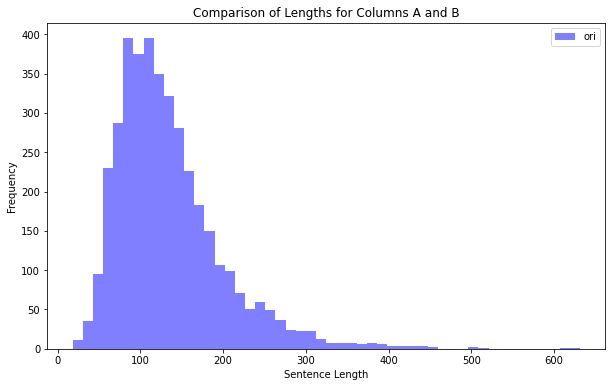

In [154]:
# 줄이기 전 
plt.figure(figsize=(10, 6))
plt.hist(train_data['conversation'].apply(len), bins=50, alpha=0.5, color='blue', label='ori')
plt.title("Comparison of Lengths for Columns A and B")
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.legend()
plt.show()

## 문장 전처리 함수 선언

### 1) `preprocess_sentence()`
1. 영어, 한국어가 아닌 경우 공백 (` `) 처리
2. 두 개 이상의 느낌표(`!+`)가 있을 경우 느낌표 하나로 처리
3. 두 개 이상의 물음표(`\?+`)가 있을 경우 물음표 하나로 처리
4. `?`, `.`, `!`, `,` 가 있을 경우 그 주위에 공백을 추가
5. 연속적인 공백이 있을 시 공백을 하나로 처리
6. 문장 앞뒤의 공백과 개행문자를 제거(`strip`)

In [155]:
def preprocess_sentence(sentence):
    emoticon_normalize(sentence)
    repeat_normalize(sentence)
    sentence = re.sub(r'([^a-zA-Zㄱ-ㅎ가-힣?.!,])', " ", sentence)
    sentence = re.sub(r'!+', '!', sentence)
    sentence = re.sub(r'\?+', '?', sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()
    return sentence

### 2) `preprocess_sentence2()`
1. 영어, 한국어가 아닌 경우 공백 (` `) 처리
2. 연속적인 공백이 있을 시 공백을 하나로 처리
3. 문장 앞뒤의 공백과 개행문자를 제거(`strip`)
4. 위 함수를 거친 문장은 문법기호(`?`, `!`, `,` 등)도 모두 제거됨

In [156]:
def preprocess_sentence2(sentence):
    emoticon_normalize(sentence)
    repeat_normalize(sentence)
    sentence = re.sub(r'([^a-zA-Zㄱ-ㅎ가-힣])', " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()
    return sentence

---

## 문장 전처리 함수를 사용하여 학습할 문장(`sentences`) 설정

In [157]:
# 학습할 문장이 담길 배열
sentences = []

for val in tqdm(train_data['conversation'], desc="Generate sentences.."):
    # preprocess_sentence2()로 문장(val)을 전처리하여 배열에 저장
    sentences.append(preprocess_sentence2(val))

Generate sentences..: 100%|██████████| 3950/3950 [00:00<00:00, 6350.93it/s]


In [158]:
#### preprocess_sentence() 케이스 사용 시 해당 함수 내용을 써보자
#### 테스트는 preprocess_sentence()를 거친 데이터 기준으로 수행됨
def dummy():
    # 학습할 문장이 담길 배열
    sentences2 = []

    for val in tqdm(train_data['conversation'], desc="Generate sentences.."):
        # preprocess_sentence()로 문장(val)을 전처리하여 배열에 저장
        sentences.append(preprocess_sentence(val))
#####

---

## 대화 종류(`class`) 문장을 숫자로 변환

---

`협박 관련 대화` &rarr; `0`  
`갈취 관련 대화` &rarr; `1`  
`직장 관련 대화` &rarr; `2`  
`기타 관련 대화` &rarr; `3`  

In [159]:
labels = []

for val in tqdm(train_data['class'], desc="class label convert to num..."):    
    if '갈취' in val:
        labels.append(1)
    if '기타' in val:
        labels.append(3)
    if '직장' in val:
        labels.append(2)
    if '협박' in val:
        labels.append(0)

class label convert to num...: 100%|██████████| 3950/3950 [00:00<00:00, 1185594.73it/s]


---

## 데이터셋(`sentences`, `labels`)을 8:2 (`train`:`test`)로 분할

In [160]:
# 데이터셋 분할
train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    sentences, labels, test_size=0.2, random_state=42
)

In [161]:
def random_deletion(words, p=0.3):
    if len(words) == 1:
        return words

    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)

    if len(new_words) == 0:
        rand_int = random.randint(0, len(words)-1)
        return [words[rand_int]]

    return ''.join(new_words)

def swap_word(new_words):
    random_idx_1 = random.randint(0, len(new_words)-1)
    random_idx_2 = random_idx_1
    counter = 0

    while random_idx_2 == random_idx_1:
        random_idx_2 = random.randint(0, len(new_words)-1)
        counter += 1
        if counter > 3:
            return new_words

    new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1]
    return new_words

def random_swap(words, n=3):
    new_words = words.copy()
    for _ in range(n):
        new_words = swap_word(new_words)

    return new_words

In [162]:
print('증강 전 : ', len(train_sentences))

증강 전 :  3160


In [163]:
train_splted = pd.DataFrame({
    'sentence': train_sentences,
    'class':train_labels
})
train_splted_rd = train_splted.copy()
train_splted_rd['sentence'] = train_splted_rd['sentence'].apply(random_deletion)



train_splted_rs = train_splted.copy()
train_splted_rs['sentence'] = random_swap(train_splted_rs['sentence'])


In [164]:
train_concated = pd.concat([train_splted,train_splted_rd,train_splted_rs])
train_concated

,sentence,class
0,네 아 죄송합니다 네 별거 바르지 않았는데 과장님 그런거 아니예요 제가 조심할께요 ...,2
1,김대리 이새까 자넨 왜 이 모양이야 너는 서류 꼴을 보고 그런 말이 나와 전부 엉망...,2
2,선생님 우리 애 성적이 왜 이래요 그러니까 성적이 왜 저러냐구요 비싼 돈 가져다 줬...,3
3,난 사이코패스야 날 보고 두려움에 떠는 여자들을 보는 게 좋아 어떻게 죽여줄까 필요...,0
4,넌 남자 잘 만나고 다닌다 음 그건 아닌고 같고 너 몸보고 만나는거아냐 노출도 심하...,3
...,...,...
3155,친구야 안녕 내가 오늘 남자친구랑 라 돈 좀 아니 뒤져서 나오면 어떻게 할래 뒤져서...,1
3156,도대체 왜 그러는거야 한밤중에 카톡에 강제 초대해서 죽은 동물 사진 보내고 욕설 보...,3
3157,약 잘 챙겨먹고있어 오늘 왜 하 죽고싶다는 말 좀 그만할래 만날 때마다 우울하다 죽...,3
3158,네 네 네 넥타이요 그래 넥타이 나는 이번에도 어머니가 골라준 줄 알았네 아니야 잘...,2


In [165]:
# train_sentences = list(train_concated['sentence'].values)
# train_labels = list(train_concated['class'].values)

---

## BERT 토크나이저 & 모델 준비
학습된 `BERT` 모델 사용 &rarr; `bert-base-multilingual-cased`

In [166]:
# BERT 토크나이저와 모델 준비
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
model = TFBertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=4)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---

## 모델 파라미터 선언

In [167]:
# 토큰 최대 길이
MAX_LEN = 200
# 데이터 묶음 크기
BATCH_SIZE = 16
# Learning Rate
lr = 5e-5 # 5e-5 , 1e-4 
# 훈련 횟수
EPOCH = 3

---

## 일반 문장을 BERT 입력 형식으로 변환
`예시` &rarr; `[CLS] 안녕하세요 [SEP]`

In [168]:
# 데이터셋을 BERT 입력 형식으로 변환
train_encodings = tokenizer(train_sentences, truncation=True, padding=True, max_length=MAX_LEN) # 뒤쪽에 패딩
val_encodings = tokenizer(val_sentences, truncation=True, padding=True, max_length=MAX_LEN)

---

## TF 데이터셋 생성

In [169]:
# TensorFlow 데이터셋 생성
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).shuffle(100).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(BATCH_SIZE)


---

## 모델 컴파일

In [170]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

---

---

## 모델 훈련

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# 스케줄러 설정
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',    # 모니터링할 지표 (검증 정확도)
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

In [171]:
epoch = EPOCH
model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=epoch,
    callbacks=[reduce_lr],
)

Epoch 1/3
198/198 [==============================] - 162s 750ms/step - loss: 1.1875 - accuracy: 0.4535 - val_loss: 1.0817 - val_accuracy: 0.5620
Epoch 2/3
198/198 [==============================] - 146s 737ms/step - loss: 0.9964 - accuracy: 0.5959 - val_loss: 0.9893 - val_accuracy: 0.6000
Epoch 3/3
198/198 [==============================] - ETA: 0s - loss: 0.8664 - accuracy: 0.6652

KeyboardInterrupt: 

In [ ]:
# lr 변경 1e-5 -> 5e-5 


In [172]:
import gc

# 메모리 해제
gc.collect()

6297

---

## 모델 평가

In [101]:
# 모델 평가
evaluation = model.evaluate(val_dataset)
print("평가 결과:", evaluation)

50/50 [==============================] - 11s 215ms/step - loss: 0.4271 - accuracy: 0.8759
평가 결과: [0.4270894229412079, 0.8759493827819824]


---

## 테스트 문장으로 모델 평가하기

### test.json 읽기

In [102]:
test_data_path ="/aiffel/aiffel/dktc/data/test.json"

with open(test_data_path, "r", encoding="utf-8") as json_file:
    test = json.load(json_file)

---

### JSON의 key별로 가지는 문장(`value`) 읽으면서 예측해보기

In [104]:
import numpy as np

test_predicst = list()

for key in test:
    test_sentence = test[key]['text']
    
    test_encodings = tokenizer(test_sentence, truncation=True, padding=True, max_length=128, return_tensors="tf")
    
    test_predictions = model.predict({
        "input_ids": test_encodings["input_ids"],
        "token_type_ids": test_encodings["token_type_ids"],
        "attention_mask": test_encodings["attention_mask"]
    }) # [ 0.7805823,  2.6188664, -2.0281641, -0.9672525]
    test_class_probabilities = tf.nn.softmax(test_predictions.logits, axis=-1).numpy() # [[0.13297564 0.8358507  0.00801584 0.02315779]]
    test_predicted_class = np.argmax(test_class_probabilities, axis=1) # [ 1 ]
    test_predicst.append(test_predicted_class[0])

---

# submission
`submission.csv`파일을 위한 DataFrame 생성

In [105]:
def labelnum_to_text(x):
    if x == 1 : # 갈취
        return '01'
    if x == 2 : # 직장
        return '02'
    if x == 3 : # 기타
        return '03'
    if x == 0 : # 협박 
        return '00'

submission = pd.DataFrame({'class':test_predicst}, index=list(test.keys()))
submission['class'] = submission['class'].apply(labelnum_to_text)
submission

,class
t_000,01
t_001,02
t_002,02
t_004,03
t_005,00
...,...
t_495,02
t_496,02
t_497,01
t_498,02


---

## 날짜별 파일 만들기

In [106]:
import datetime

# 현재 날짜와 시간 가져오기
now = datetime.datetime.now()

# 날짜와 시간을 원하는 형식으로 포맷팅
date_time_str = now.strftime("%Y%m%dT%H%M")

# 파일명 생성
file_name = f"submission{date_time_str}.csv"

# submission.csv 파일을 날짜패턴 합쳐 만들기
submission.to_csv(file_name)

### `preprocess_sentence2()` 전처리 출발 케이스